In [255]:
import cv2
import os
import glob
import numpy as np
import matplotlib.pyplot as plt

In [256]:
# config
# image_folder = r'D:\Dataset\kittimot\testing\image_02'
# calib_folder = r'D:\Dataset\kittimot\testing\calib'
image_folder = r'G:\내 드라이브\data\kittimot\testing\image_02'
calib_folder = r'G:\내 드라이브\data\kittimot\testing\calib'
calib_list = glob.glob(os.path.join(calib_folder, '*.txt'))

SEQ = 9 # training: 0~20, testing: 0~28
FRAME = 100
image_list = glob.glob(os.path.join(image_folder, f'{SEQ:04d}', '*.png'))

yolo_result_folder = './results/yolov5_test'
yolo_label_list = glob.glob(os.path.join(yolo_result_folder, '*.txt'))
rrcCar_result_folder = './results/rrc_car_test'
rrcCar_result_list = glob.glob(os.path.join(rrcCar_result_folder, '*.txt'))
pointrcnn_result_folder_df = './results/pointrcnn_test/deepfusionmot/'
pointrcnn_result_list_df = glob.glob(os.path.join(pointrcnn_result_folder_df, '*.txt'))
pointrcnn_result_folder_pius = './results/pointrcnn_test/pius/'
pointrcnn_result_list_pius = glob.glob(os.path.join(pointrcnn_result_folder_pius, '*.txt'))

calib_list.sort()
image_list.sort()
yolo_label_list.sort()
rrcCar_result_list.sort()
pointrcnn_result_list_df.sort()
pointrcnn_result_list_pius.sort()

In [257]:
def load_label(label_list, seq):
    with open(label_list[seq], 'r') as f:
        label = f.read().splitlines()
    label = np.array([x.split(',') for x in label])
    return label

# visualize 2D

In [258]:
def make_rect(label, frame, sequence, dim = '2d'):
    r'''
    args:
        label: 2d [frame, left, top, right, bottom, score], 3d [frame, id, left, top, right, bottom, score, h, w, l, x, y, z, r_y, alpha]
        frame: frame number
        sequence: sequence number
        dim: '2d' or '3d'
    '''
    if not dim.lower() in ['2d', '3d']:
        raise ValueError('dim should be 2d or 3d')
    
    if dim.lower() == '2d':
        rect = np.array([x[1:5] for x in label if x[0] == f'{frame}'], dtype=np.float32)
    elif dim.lower() == '3d':
        rect = np.array([x[2:6] for x in label if x[0] == f'{frame}'], dtype=np.float32)
    
    return rect

In [259]:
def draw_projected_box3d(image, qs, color=(255,255,255), thickness=2):
    ''' Draw 3d bounding box in image
        qs: (8,2) array of vertices for the 3d box in following order:
            1 -------- 0
           /|         /|
          2 -------- 3 .
          | |        | |
          . 5 -------- 4
          |/         |/
          6 -------- 7
    '''
    if qs is not None:
        qs = qs.astype(np.int32)
        for k in range(0,4):
           i,j=k,(k+1)%4
           image = cv2.line(image, (qs[i,0],qs[i,1]), (qs[j,0],qs[j,1]), color, thickness) # use LINE_AA for opencv3

           i,j=k+4,(k+1)%4 + 4
           image = cv2.line(image, (qs[i,0],qs[i,1]), (qs[j,0],qs[j,1]), color, thickness)

           i,j=k,k+4
           image = cv2.line(image, (qs[i,0],qs[i,1]), (qs[j,0],qs[j,1]), color, thickness)
    return image

# cv2 image plt show method
def imshow(title = "Image", image = None, size = 20, rect = None, corners_2d = None):
    w, h = image.shape[0], image.shape[1]
    aspect_ratio = w/h
    img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # draw 2d bbox
    for r in rect if rect is not None else []:
        img = cv2.rectangle(img, (int(r[0]), int(r[1])), (int(r[2]), int(r[3])), (0, 255, 0), 2)
    
    # draw 3d bbox
    for corners in corners_2d if corners_2d is not None else []:
        img = draw_projected_box3d(img, corners, color = (255, 0, 0), thickness = 1)
    
    plt.figure(figsize=(size * aspect_ratio,size))
    plt.imshow(img)
    plt.axis( "off" )
    plt.title(title)
    plt.show()
    
def readLabel(label_path):
    with open(label_path,  "r" ) as f:
        label = f.read().splitlines()
    return label

def showkitti(idx: int, datasets, rect, split: str = "test", seq: int = None, frame: int = None):
    r'''
    args:
        - idx(int): index of the image
        - datasets(str): "kitti" or "kittimot"
        - split(str): test
        - seq(int): sequence number train: 0 ~ 20, test: 0 ~ 28
        - frame(int): frame number
    '''
    
    SPLIT = {"train": "training", "test": "testing"}
    
    if datasets == "kitti":
        kitti_path = f"/data/hwang/datasetss/{datasets}" # your kitti path
        image_list = glob(os.path.join(kitti_path, SPLIT[split], "image_2", "*.png"))
        image_list.sort()
        label_list = glob(os.path.join(kitti_path, SPLIT[split], "label_2", "*.txt"))
        label_list.sort()

        label = np.array([x.split(' ') for x in readLabel(label_list[idx]) if not x[:4] == 'Dont']).reshape(-1, 15)
        rect = np.array([x[4:8].astype(np.float32) for x in label])

        imshow("Image", cv2.imread(image_list[idx]), size = 30, rect=rect)
        print(label)
        
    elif datasets == "kittimot":
        kitti_path = f"/data/hwang/datasetss/{datasets}" # your kittimot path
        
        image_list = glob(os.path.join(kitti_path, SPLIT[split], "image_02",f'{seq:04d}', "*.png"))
        label_list = glob(os.path.join(kitti_path, SPLIT[split], "label_02", "*.txt"))
        image_list.sort()
        label_list.sort()
        
        try:
            label = np.array([x.split(' ') for x in readLabel(label_list[seq])]).reshape(-1, 17)
        except:
            print("not enough arguments")
        
        rect = np.array([x[6:10].astype(np.float32) for x in label if x[0] == f'{frame}' and x[2] != 'DontCare'])
        imshow("Image", cv2.imread(image_list[frame]), size = 30, rect=rect)
        for l in label:
            if l[0] == str(frame) and l[2] != "DontCare":
                print(l)

In [260]:
# pointrcnn label
yolo_label = load_label(yolo_label_list, SEQ)
pointrcnn_label = load_label(pointrcnn_result_list_df, SEQ)
pointrcnn_label_pius = load_label(pointrcnn_result_list_pius, SEQ)

In [261]:
image = cv2.imread(image_list[FRAME])
rect_2d = make_rect(yolo_label, FRAME, SEQ, dim='2d')
rect_3d_df = make_rect(pointrcnn_label, FRAME, SEQ, dim='3d')
rect_3d_pius = make_rect(pointrcnn_label_pius, FRAME, SEQ, dim='3d')

In [262]:
#imshow("Image", image, size = 40, rect=rect_3d_df)
#imshow("Image", image, size = 40, rect=rect_3d_pius)

# visualize 3D boxes on 2D image

In [263]:
import cv2, random
from PIL import Image
from datasets.coordinate_transformation import *

MAX_COLOR = 30
SCORE_THRESHOLD = -10000
WIDTH = 1242
HEIGHT = 374

In [264]:
pointrcnn_bbox3d = np.array([x[7:].astype(np.float32) for x in pointrcnn_label if x[0] == f'{FRAME}'])
calib_file = calib_list[SEQ]
corners_3d = []
for bbox3d in pointrcnn_bbox3d:
    corners_3d.append(compute_box_3dto2d(bbox3d, calib_file)[0])
corners_3d = np.array(corners_3d)

In [265]:
pointrcnn_bbox3d_pius = np.array([x[7:].astype(np.float32) for x in pointrcnn_label_pius if x[0] == f'{FRAME}'])
corners_3d_pius = []
for bbox3d in pointrcnn_bbox3d_pius:
    corners_3d_pius.append(compute_box_3dto2d(bbox3d, calib_file)[0])
corners_3d_pius = np.array(corners_3d_pius)

In [266]:
pointrcnn_bbox3d

array([[ 1.613 ,  1.6972,  4.2041, -1.536 ,  2.2107, 31.2907, -1.5845,
        -1.5355]], dtype=float32)

In [267]:
pointrcnn_bbox3d_pius

array([[ 1.59850e+00,  1.64860e+00,  3.96030e+00, -1.09800e+00,
         1.66440e+00,  3.14554e+01, -1.36000e-02]], dtype=float32)

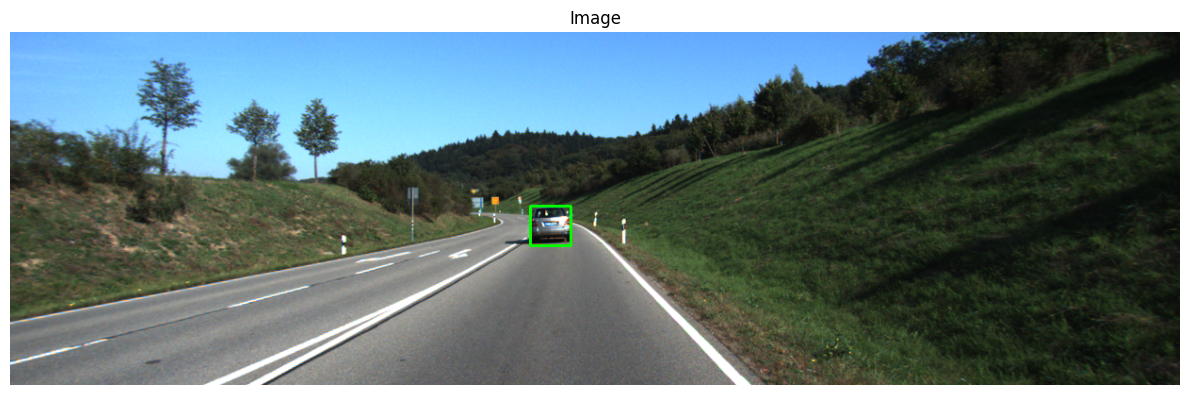

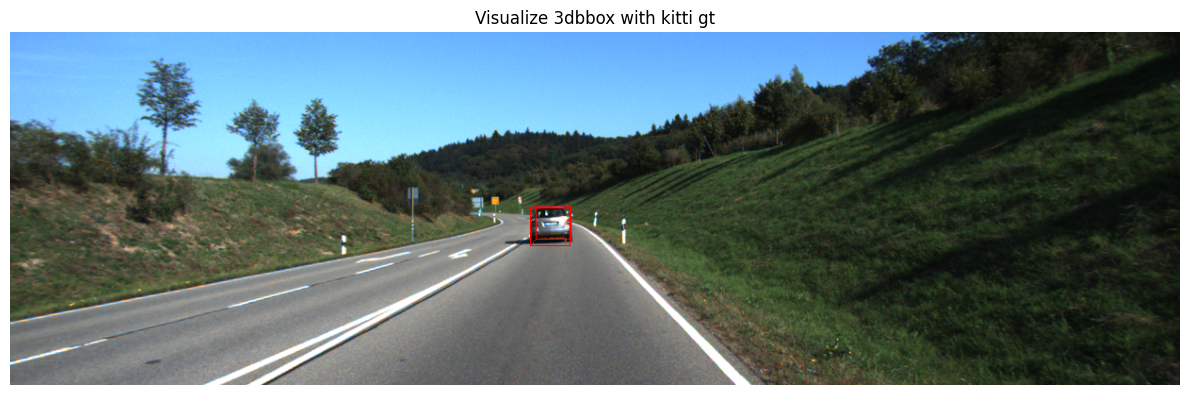

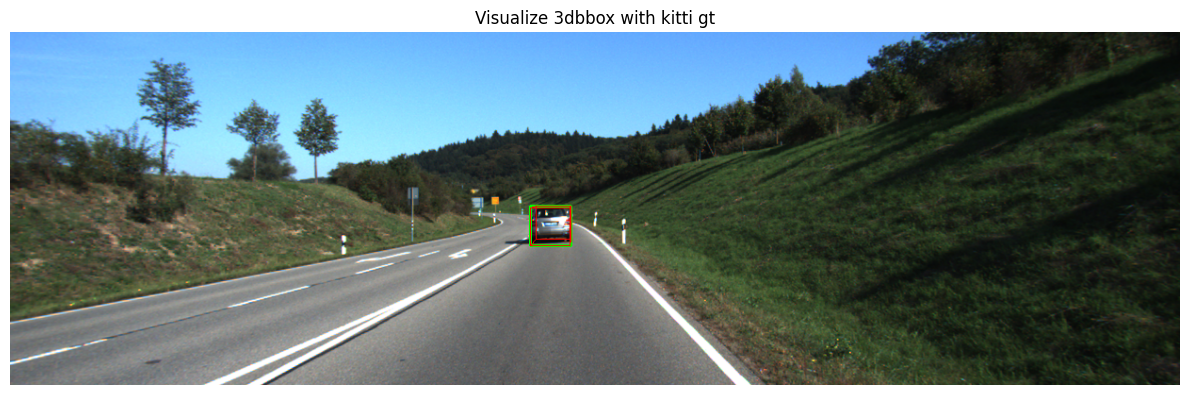

In [268]:
imshow("Image", image, size = 50, rect=rect_3d_df)
imshow("Visualize 3dbbox with kitti gt", image, size = 50, corners_2d=corners_3d)
imshow("Visualize 3dbbox with kitti gt", image, size = 50, rect=rect_3d_df, corners_2d=corners_3d)

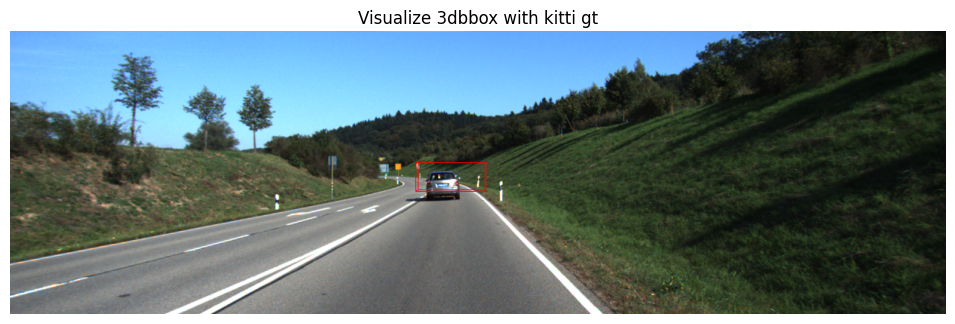

In [269]:
imshow("Visualize 3dbbox with kitti gt", image, size = 40, corners_2d=corners_3d_pius)

# Visualize 3D boxes on 3D point cloud

In [270]:
import open3d as o3d


# calculate alpha

In [271]:
null

NameError: name 'null' is not defined

In [ ]:
import math

class obj(object):
    def __init__(self, result3d =  None, label = None):
        if label is not None:
            self.frame = int(label[0])
            self.type = int(label[1])
            self.h = float(label[7])
            self.w = float(label[8])
            self.l = float(label[9])
            self.x = float(label[10])
            self.y = float(label[11])
            self.z = float(label[12])
            self.ry = float(label[13])
        elif result3d is not None:
            result3d = self.splitObjComponents(result3d)
            self.frame = int(result3d[0])
            self.type = int(result3d[1]) # 1: ped, 2: car, 3: cyclist
            self.h = float(result3d[2])
            self.w = float(result3d[3])
            self.l = float(result3d[4])
            self.x = float(result3d[5])
            self.y = float(result3d[6])
            self.z = float(result3d[7])
            self.ry = float(result3d[8])
            self.alpha = float(result3d[9])
    
    def splitObjComponents(self, result3d):
        result3d = result3d.split(",")
        return result3d
      

def normalizeAngle(angle):
    result = angle % (2*math.pi)
    if result < -math.pi:
        result += 2*math.pi
    elif result > math.pi:
        result -= 2*math.pi
    return result

def cal_alpha_ori(obj: obj):  
    alpha = obj.ry
    alpha -= -math.atan2(obj.z, obj.x) -1.5*math.pi 
    alpha = normalizeAngle(alpha)
    return alpha # -1.818032754845337

# frame, type, h, w, l, x, y, z, yaw, alpha
obj1 = obj(result3d="0,2,1.5599,1.5848,3.4791,2.5702,1.5720,9.7190,-1.5595,-1.8180")
cal_alpha_ori(obj1)

-1.818032754845337

In [ ]:
idx = 1
obj2 = obj(label=pointrcnn_label[idx])
print(pointrcnn_label[idx])
cal_alpha_ori(obj2)

['0' '2' '679.6621' '174.1462' '795.2264' '260.7374' '12.8676' '1.5694'
 '1.6609' '4.1846' '2.4745' '1.6008' '15.2377' '-1.5807' '-1.7417']


-1.7416879230707938

In [ ]:
def save_label(label, save_path):
    with open(os.path.join(save_path), "w") as f:
        for line in label:
            f.write(",".join([str(i) for i in line]) + "\n")

In [ ]:
null

NameError: name 'null' is not defined

# fix all pius results

In [ ]:
# fix all pius results
for seq, result_file in enumerate(pointrcnn_result_list_pius):
    pointrcnn_label_pius = load_label(pointrcnn_result_list_pius, seq)
    pointrcnn_label_pius = pointrcnn_label_pius[:, [0, 1, 2, 3, 4, 5, 13, 6, 7, 8, 9, 10, 11, 12]]
    pointrcnn_label_pius = np.insert(pointrcnn_label_pius, 14, 0, axis=1)
    
    # calculate alpha and change pointrcnn_label_pius's 14th column
    for idx, label in enumerate(pointrcnn_label_pius):
        pointrcnn_label_pius[idx][14] = cal_alpha_ori(obj(label=label))
    
    save_label(pointrcnn_label_pius, save_path=result_file)